In [18]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
file_path = 'dataset/MCFP特徵集.csv'
data = pd.read_csv(file_path)

# data = data.sample(20000)

In [36]:
data["label"].value_counts(normalize=True)

1    0.513031
0    0.486969
Name: label, dtype: float64

In [37]:
# 保留所有必要的特徵，包括 certificate 和 curve
data_cleaned = data.copy()

In [38]:
# 將需要進行編碼的特徵進行 Label Encoding
label_encoders = {}
for column in ['version', 'cipher', 'certificate', 'curve']:
    le = LabelEncoder()
    data_cleaned[column] = le.fit_transform(data_cleaned[column])
    label_encoders[column] = le

In [39]:
# 分離特徵和標籤
X = data_cleaned.drop(columns=['label'])
y = data_cleaned['label']

In [40]:
# 標準化數據
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [41]:
# 將標籤轉換為 one-hot 編碼
y_categorical = to_categorical(y)

In [42]:
# 分割數據集為訓練集（70%）和測試集（30%）
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_categorical, test_size=0.3, random_state=42)

In [43]:
# 優化的 LSTM 模型
def create_lstm_model(input_shape):
    model = Sequential()
    # 增加模型深度和單元數
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.3)) # 防止過擬合的 Dropout 層
    model.add(LSTM(64)) # 再添加一個 LSTM 層
    model.add(Dropout(0.3))
    # 使用更高維度的 Dense 層來進行分類
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))  # 兩個類別，使用 softmax 激活函數
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # 優化器使用 Adam
    return model

In [44]:
# 設定 k-fold 交叉驗證
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []

In [45]:
# 將數據重新塑形為 LSTM 格式 (樣本數, 時間步長, 特徵數)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [46]:
# 執行 k-fold 交叉驗證
for train_index, val_index in kfold.split(X_train_lstm):
    model = create_lstm_model((1, X_train.shape[1]))
    
    # 訓練模型，增加 epochs 次數和減少 batch_size 以提高訓練精度
    model.fit(X_train_lstm[train_index], y_train[train_index], epochs=5, batch_size=16, verbose=0)
    
    # 驗證模型
    val_predictions = model.predict(X_train_lstm[val_index])
    val_predictions_classes = np.argmax(val_predictions, axis=1)
    val_true_classes = np.argmax(y_train[val_index], axis=1)
    
    # 計算準確率並儲存
    accuracy = accuracy_score(val_true_classes, val_predictions_classes)
    scores.append(accuracy)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [47]:
# 在測試集上評估最終模型
test_predictions = model.predict(X_test_lstm)
test_predictions_classes = np.argmax(test_predictions, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

664/664 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [48]:
# 計算評估指標
accuracy = accuracy_score(y_test_classes, test_predictions_classes)
precision = precision_score(y_test_classes, test_predictions_classes, average='weighted')
recall = recall_score(y_test_classes, test_predictions_classes, average='weighted')
f1 = f1_score(y_test_classes, test_predictions_classes, average='weighted')

In [49]:
# 將結果整理成 DataFrame
test_results = {
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1-Score': [f1]
}

results_df = pd.DataFrame(test_results)
print(results_df)

   Accuracy  Precision    Recall  F1-Score
0  0.999906   0.999906  0.999906  0.999906


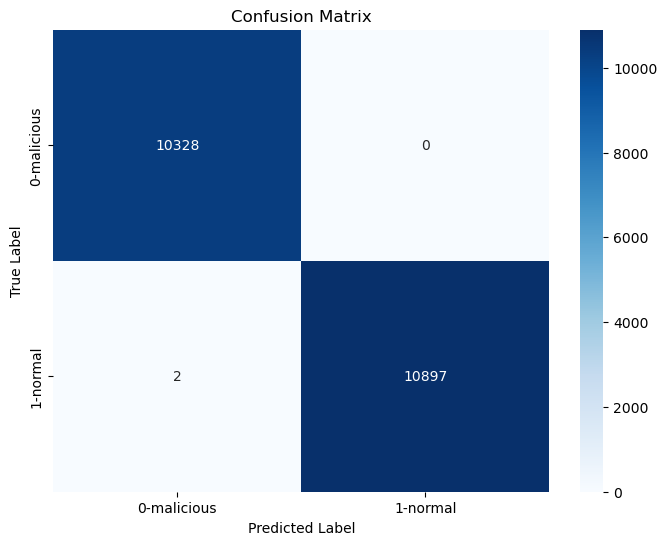

In [50]:
# 畫出混淆矩陣圖表
cm = confusion_matrix(y_test_classes, test_predictions_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0-malicious', '1-normal'], yticklabels=['0-malicious', '1-normal'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()